In [8]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display,Markdown

import numpy as np
import math
from scipy.integrate import solve_ivp
from hjb import *

#reverse tree works quite badly without integration
INTEGRATE = True
INTEGRATION_REL_TOLERANCE = 1e-2
INTEGRATION_ABS_TOLERANCE = 1e-4

class PendulumDynamics(DynamicSystem):
    """The state space is (theta, theta') and the control is the torque.
    """
    def __init__(self,m=1,L=1,g=1):
        self.m = m
        self.L = L
        self.g = g
    
    def dynamics(self,state,control):
        return np.array([state[1],-self.g/self.L*np.cos(state[0]) + control/(self.m*self.L)])

    def nextState(self,state,control,dt):
        if dt < 0:
            #allow reverse dynamics
            if INTEGRATE:
                res = solve_ivp((lambda t,y:-self.dynamics(y,control)),[0,-dt],state,rtol=INTEGRATION_REL_TOLERANCE,atol=INTEGRATION_ABS_TOLERANCE)
                x = res.y[:,-1]
            else:
                x = state + dt*self.dynamics(state,control)
        else:
            if INTEGRATE:
                res = solve_ivp((lambda t,y:self.dynamics(y,control)),[0,dt],state,rtol=INTEGRATION_REL_TOLERANCE,atol=INTEGRATION_ABS_TOLERANCE)
                x = res.y[:,-1]
            else:
                x = state + dt*self.dynamics(state,control)
        #normalize the angle
        x[0] = x[0]%(2.0*math.pi)
        if x[0] < 0:
            x[0] += (2.0*math.pi)
        return x
    
    def validState(self,state):
        return True

    def validControl(self,state,control):
        return True

class PendulumControlSampler(ControlSampler):
    def __init__(self,umin,umax):
        self.umin = umin
        self.umax = umax
    def sample(self,state):
        return [self.umin,0,self.umax]
    
class TimeObjectiveFunction(ObjectiveFunction):
    def edgeCost(self,state,control,dt,nextState):
        return abs(dt)
    
class EffortObjectiveFunction(ObjectiveFunction):
    def edgeCost(self,state,control,dt,nextState):
        return np.linalg.norm(control)**2*dt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
#create the dynamics function, terminal conditions, and control bounds
dynamics = PendulumDynamics()
umin = -0.25
umax = 0.25
start = np.array([math.pi*3/2,0])
right = np.array([0,0])
goal = np.array([math.pi/2,0])
bounds = [(0,math.pi*2),(-5,5)]
controlSampler = PendulumControlSampler(umin,umax)
objective = TimeObjectiveFunction()

In [10]:
#some debugging of the dynamics function
print "NextState from right, 0.1s",dynamics.nextState(right,0,0.1)
print "NextState from right, 0.5s",dynamics.nextState(right,0,0.5)
x = right
t = 0
while t < 0.5:
    x = dynamics.nextState(x,0,0.01)
    t += 0.01
print "Euler integration 0.5s, 0.01s substep",x
print "Reverse 0.1s",dynamics.nextState(right,0,-0.1)
print "Forward then reverse 0.1s",dynamics.nextState(dynamics.nextState(right,0,0.1),0,-0.1)
print "Reverse then forward 0.1s",dynamics.nextState(dynamics.nextState(right,0,-0.1),0,0.1)
print "Forward then reverse 0.1s, umin",dynamics.nextState(dynamics.nextState(right,umin,0.1),umin,-0.1)
print "Reverse then forward 0.1s, umin",dynamics.nextState(dynamics.nextState(right,umin,-0.1),umin,0.1)

NextState from right, 0.1s [ 6.27818531 -0.09999975]
NextState from right, 0.5s [ 6.15825044 -0.49921979]
Euler integration 0.5s, 0.01s substep [ 6.15825036 -0.49921977]
Reverse 0.1s [6.27818531 0.09999975]
Forward then reverse 0.1s [ 3.45679041e-11 -5.26106936e-14]
Reverse then forward 0.1s [3.45679041e-11 5.26106936e-14]
Forward then reverse 0.1s, umin [ 5.40083533e-11 -9.71167591e-14]
Reverse then forward 0.1s, umin [5.40083533e-11 9.71167591e-14]


In [11]:
#testing the RobustRegularGridInterpolator
xdivs = np.array([0,1,2])
ydivs = np.array([0,1,2])
values = np.arange(9,dtype=float).reshape((3,3))
values[0,0] = float('inf')
values[0,1] = float('inf')
print values
grid = RobustRegularGridInterpolator((xdivs,ydivs),values)
print grid([0.1,0.5]),"should be inf"
print grid([0.6,0.5]),"should be 3.5"

[[inf inf  2.]
 [ 3.  4.  5.]
 [ 6.  7.  8.]]
3.5 should be inf
3.5 should be 3.5


In [12]:
hjb = HJBSolver(dynamics,controlSampler,0.1,objective,
                bounds,[200,200],
                goal=goal)
scell = hjb.stateToCell(start)
print bounds
print "Start cell",scell
print "Start cell center",hjb.cellToCenterState(scell)
print "cell of Start cell center",hjb.stateToCell(hjb.cellToCenterState(scell))
hjb.value[scell] = 0
print "Start interpolator index",hjb.valueInterpolator.getCell(start)
print "Start interpolator value",hjb.valueInterpolator(start)
print "Start cell center interpolator index",hjb.valueInterpolator.getCell(hjb.cellToCenterState(scell))
print "Start cell center interpolator value",hjb.valueInterpolator(hjb.cellToCenterState(scell))


[(0, 6.283185307179586), (-5, 5)]
Start cell (150, 100)
Start cell center [4.72809694 0.025     ]
cell of Start cell center (150, 100)
Start interpolator index [149, 99]
Start interpolator value 0.0
Start cell center interpolator index [150, 99]
Start cell center interpolator value 0.0


# HJB Solver

<IPython.core.display.Javascript object>


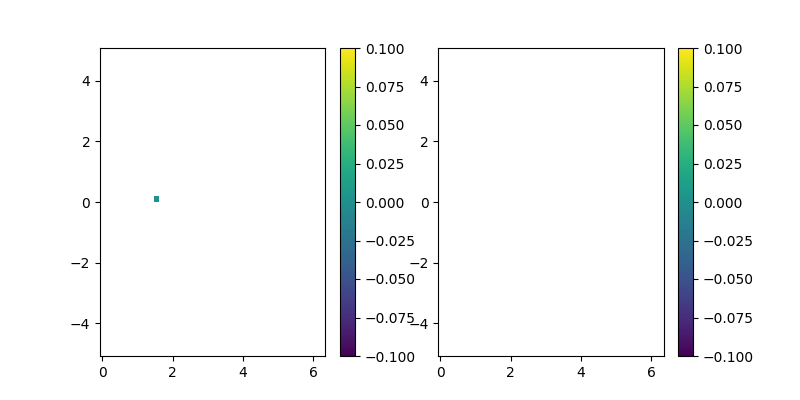

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0xMSwgZGVzY3JpcHRpb249dSdpJywgbWF4PTEwMSwgbWluPTEsIHN0ZXA9MTApLCBCdXR0b24oZGVzY3JpcHRpb249dSdSdW7igKY=


In [13]:
#need to set dt large enough to have a chance to jump cells
dt = 0.3
hjb = HJBSolver(dynamics,controlSampler,dt,objective,
                bounds,[50,60],
                goal=goal)

display(Markdown("# HJB Solver"))
hjbdisplay = GridCostFunctionDisplay(hjb,hjb.value,hjb.policy,policyDims=None)
hjbdisplay.show()

def do_value_iteration(i):
    print "Running",i,"HJB iterations"
    hjb.valueIteration(iters=i)
    hjbdisplay.refresh(hjb.value,hjb.policy)
    if hjb.getPolicy(start) is not None:
        #show the HJB policy 
        xs,us = rolloutPolicy(dynamics,start,(lambda x:hjb.getPolicy(x)),dt*0.5,200)
        hjbdisplay.plotTrajectory(xs,color='r',zorder=3)
        
        la_policy = LookaheadPolicy(dynamics,dt,controlSampler,objective,(lambda x:False),hjb.interpolateValue)
        xs,us = rolloutPolicy(dynamics,start,la_policy,dt,200)
        hjbdisplay.plotTrajectory(xs,color='y',zorder=4)
    hjbdisplay.plotFlow(lambda x:hjb.getPolicy(x))
interact_manual(do_value_iteration,i=widgets.IntSlider(min=1, max=101, step=10, value=11));


# Backward Solver

<IPython.core.display.Javascript object>


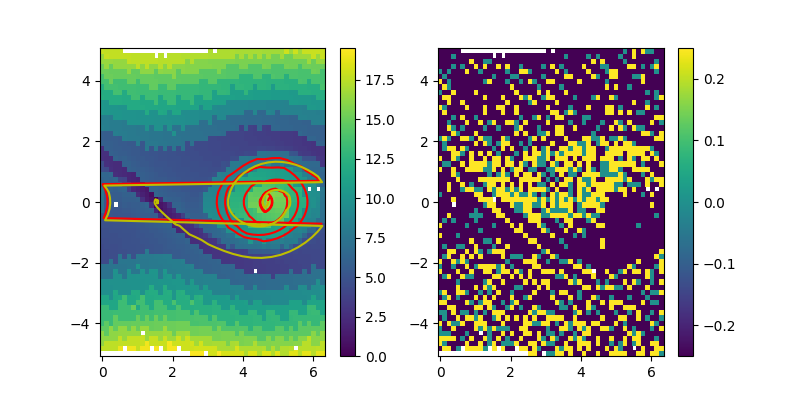

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0xMDAxLCBkZXNjcmlwdGlvbj11J04nLCBtYXg9MTAwMDEsIG1pbj0xLCBzdGVwPTEwMCksIEJ1dHRvbihkZXNjcmlwdGlvbj3igKY=


In [14]:
#this does backward search with a TreeSolver
bwtree = OptimalControlTreeSolver(dynamics,controlSampler,-dt*0.5,objective,
                bounds,[50,60],
                start=goal,goal=(lambda x:False),terminalAsStartCost=True)
bwtree.maxVisitedPerCell = 10

display(Markdown("# Backward Solver"))
bwtreedisplay = GridCostFunctionDisplay(bwtree,bwtree.costToCome(),bwtree.reversePolicy(),policyDims=None)
bwtreedisplay.show()

def do_bw_search(N):
    for i in range(N):
        bwtree.search_step()
    #bwtree.search()
    print "Generated",bwtree.num_nodes(),"nodes"
    bwtreedisplay.refresh(bwtree.costToCome(),bwtree.reversePolicy())

    if bwtree.getReversePolicy(start) is not None:
        xs,us = rolloutPolicy(dynamics,start,(lambda x:bwtree.getReversePolicy(x)),-bwtree.dt,200)
        bwtreedisplay.plotTrajectory(xs,color='r',zorder=3)
        
        ctc_interp = bwtree.costToComeInterpolator()
        #la_policy = LookaheadPolicy(dynamics,-bwtree.dt,bwtree.controlSampler,bwtree.objective,(lambda x:False),bwtree.getCostToCome)
        la_policy = LookaheadPolicy(dynamics,-bwtree.dt,bwtree.controlSampler,bwtree.objective,(lambda x:False),ctc_interp)
        xs,us = rolloutPolicy(dynamics,start,la_policy,-bwtree.dt,200)
        bwtreedisplay.plotTrajectory(xs,color='y',zorder=4)
    else:
        #bwtreedisplay.plotGraph(color='r',lw='0.5')
        pass

    
interact_manual(do_bw_search,N=widgets.IntSlider(min=1, max=10001, step=100, value=1001));



# Forward Solver

<IPython.core.display.Javascript object>


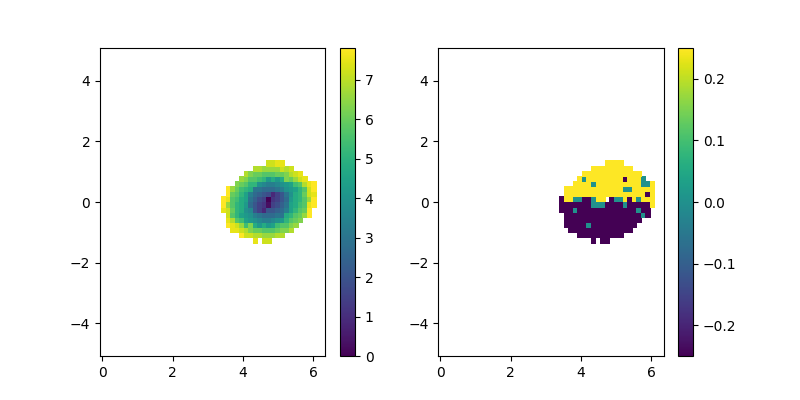

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0xMDAxLCBkZXNjcmlwdGlvbj11J04nLCBtYXg9MTAwMDEsIG1pbj0xLCBzdGVwPTEwMCksIEJ1dHRvbihkZXNjcmlwdGlvbj3igKY=


In [15]:
#this does forward search
tree = OptimalControlTreeSolver(dynamics,controlSampler,dt,objective,
                bounds,[50,60],
                start=start,goal=goal)
tree.maxVisitedPerCell = 15


display(Markdown("# Forward Solver"))
treedisplay = GridCostFunctionDisplay(tree,tree.costToCome(),tree.reversePolicy(),policyDims=None)
treedisplay.show()

def do_fw_search(N):
    for i in range(N):
        tree.search_step()
    treedisplay.refresh(tree.costToCome(),tree.reversePolicy())

    path = tree.result_path()
    if tree.goal is not None:
        assert len(path) > 0
    if len(path) > 0:
        if len(path[0].state)==0:
            path = path[1:]
        if path[-1].state == None:
            path = path[:-1]
        xs = np.array([n.state for n in path])
        treedisplay.plotTrajectory(xs,color='r',zorder=3)

interact_manual(do_fw_search,N=widgets.IntSlider(min=1, max=10001, step=100, value=1001));
